In [1]:
''' Examples of transformation & camera model.
'''
import os, sys
import numpy as np
import math
import scipy.io as sio
from skimage import io
from time import time
import subprocess

sys.path.append('..')
import face3d
from face3d import mesh

In [2]:
def transform_test(vertices, obj, camera, h = 256, w = 256):
	'''
	Args:
		obj: dict contains obj transform paras
		camera: dict contains camera paras
	'''
	R = mesh.transform.angle2matrix(obj['angles'])
	transformed_vertices = mesh.transform.similarity_transform(vertices, obj['s'], R, obj['t'])
	
	if camera['proj_type'] == 'orthographic':
		projected_vertices = transformed_vertices
		image_vertices = mesh.transform.to_image(projected_vertices, h, w)
	else:

		## world space to camera space. (Look at camera.) 
		camera_vertices = mesh.transform.lookat_camera(transformed_vertices, camera['eye'], camera['at'], camera['up'])
		## camera space to image space. (Projection) if orth project, omit
		projected_vertices = mesh.transform.perspective_project(camera_vertices, camera['fovy'], near = camera['near'], far = camera['far'])
		## to image coords(position in image)
		image_vertices = mesh.transform.to_image(projected_vertices, h, w, True)

	rendering = mesh.render.render_colors(image_vertices, triangles, colors, h, w)
	rendering = np.minimum((np.maximum(rendering, 0)), 1)
	return rendering

In [3]:
# --------- load mesh data
C = sio.loadmat('Data/example1.mat')
vertices = C['vertices']; 
global colors
global triangles
colors = C['colors']; triangles = C['triangles']
colors = colors/np.max(colors)
# move center to [0,0,0]
vertices = vertices - np.mean(vertices, 0)[np.newaxis, :]

# save folder
save_folder = 'results/transform'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
options = '-delay 10 -loop 0 -layers optimize' # gif options. need ImageMagick installed.

# ---- start
obj = {}
camera = {}
### face in reality: ~18cm height/width. set 180 = 18cm. image size: 256 x 256
scale_init = 180/(np.max(vertices[:,1]) - np.min(vertices[:,1])) # scale face model to real size

## 1. fix camera model(stadard camera& orth proj). change obj position.
camera['proj_type'] = 'orthographic'
# scale
for factor in np.arange(0.5, 1.2, 0.1):
	obj['s'] = scale_init*factor
	obj['angles'] = [0, 0, 0]
	obj['t'] = [0, 0, 0]
	image = transform_test(vertices, obj, camera) 
	io.imsave('{}/1_1_{:.2f}.jpg'.format(save_folder, factor), image)

# angles
for i in range(3):
	for angle in np.arange(-50, 51, 10):
		obj['s'] = scale_init
		obj['angles'] = [0, 0, 0]
		obj['angles'][i] = angle
		obj['t'] = [0, 0, 0]
		image = transform_test(vertices, obj, camera) 
		io.imsave('{}/1_2_{}_{}.jpg'.format(save_folder, i, angle), image)
subprocess.call('convert {} {}/1_*.jpg {}'.format(options, save_folder, save_folder + '/obj.gif'), shell=True)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

0

In [4]:
## 2. fix obj position(center=[0,0,0], front pose). change camera position&direction, using perspective projection(fovy fixed)
obj['s'] = scale_init
obj['angles'] = [0, 0, 0]
obj['t'] = [0, 0, 0]
# obj: center at [0,0,0]. size:200

camera['proj_type'] = 'perspective'
camera['at'] = [0, 0, 0]
camera['near'] = 1000
camera['far'] = -100
# eye position
camera['fovy'] = 30
camera['up'] = [0, 1, 0] #
# z-axis: eye from far to near, looking at the center of face
for p in np.arange(500, 250-1, -40): # 0.5m->0.25m
	camera['eye'] = [0, 0, p]  # stay in front of face
	image = transform_test(vertices, obj, camera) 
	io.imsave('{}/2_eye_1_{}.jpg'.format(save_folder, 1000-p), image)

# y-axis: eye from down to up, looking at the center of face
for p in np.arange(-300, 301, 60): # up 0.3m -> down 0.3m
	camera['eye'] = [0, p, 250] # stay 0.25m far
	image = transform_test(vertices, obj, camera) 
	io.imsave('{}/2_eye_2_{}.jpg'.format(save_folder, p/6), image)

# x-axis: eye from left to right, looking at the center of face
for p in np.arange(-300, 301, 60): # left 0.3m -> right 0.3m
	camera['eye'] = [p, 0, 250] # stay 0.25m far
	image = transform_test(vertices, obj, camera) 
	io.imsave('{}/2_eye_3_{}.jpg'.format(save_folder, -p/6), image)

# up direction
camera['eye'] = [0, 0, 250] # stay in front
for p in np.arange(-50, 51, 10):
	world_up = np.array([0, 1, 0]) # default direction
	z = np.deg2rad(p)
	Rz=np.array([[math.cos(z), -math.sin(z), 0],
                 [math.sin(z),  math.cos(z), 0],
                 [     0,       0, 1]])
	up = Rz.dot(world_up[:, np.newaxis]) # rotate up direction
	# note that: rotating up direction is opposite to rotating obj
	# just imagine: rotating camera 20 degree clockwise, is equal to keeping camera fixed and rotating obj 20 degree anticlockwise.
	camera['up'] = np.squeeze(up)
	image = transform_test(vertices, obj, camera) 
	io.imsave('{}/2_eye_4_{}.jpg'.format(save_folder, -p), image)

subprocess.call('convert {} {}/2_*.jpg {}'.format(options, save_folder, save_folder + '/camera.gif'), shell=True)

# -- delete jpg files
print('gifs have been generated, now delete jpgs')
subprocess.call('rm {}/*.jpg'.format(save_folder), shell=True)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

gifs have been generated, now delete jpgs


0

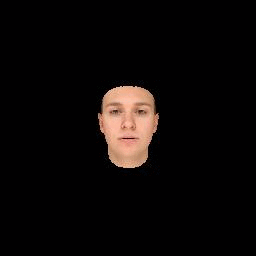

In [6]:
from IPython.display import Image
Image('results/transform/camera.gif')

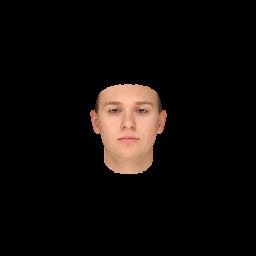

In [8]:
Image('results/transform/obj.gif')